# 1. Feature extraction

## 1.1 Nod vs other dataset

In [2]:
import os
import numpy as np
from utils import get_peaks_params
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

input_dir_prefix = './../data/'

In [3]:
# Construct feature matrix nX and vector of labels ny
other_x_widths, other_x_heights = get_peaks_params(input_dir=input_dir_prefix + 'other', angle_type='x', include_nan=False)
shake_x_widths, shake_x_heights = get_peaks_params(input_dir=input_dir_prefix + 'shake', angle_type='x', include_nan=False)
nod_x_widths, nod_x_heights = get_peaks_params(input_dir=input_dir_prefix + 'nod', angle_type='x', include_nan=False)

nX = np.array([
    [*other_x_widths, *shake_x_widths, *nod_x_widths], 
    [*other_x_heights, *shake_x_heights, *nod_x_heights]
]).T
ny = np.array([0] * (len(other_x_widths) + len(shake_x_widths)) + [1] * len(nod_x_widths))
print(nX.shape, ny.shape)
print(f'Original number of examples per class: {np.unique(ny, return_counts=True)}')

# Z-normalize features
n_znorm_scaler = StandardScaler()
nX = n_znorm_scaler.fit_transform(nX)

# Random oversampling of minority classes
random_state = 37
ros = RandomOverSampler(random_state=random_state)
nX, ny = ros.fit_resample(nX, ny)

# Shuffle data
nX, ny = shuffle(nX, ny, random_state=random_state)

print(nX.shape, ny.shape, 146*2)
print(f'After oversampling, number of examples per class: {np.unique(ny, return_counts=True)}')

(263, 2) (263,)
Original number of examples per class: (array([0, 1]), array([117, 146]))
(292, 2) (292,) 292
After oversampling, number of examples per class: (array([0, 1]), array([146, 146]))


## 1.2 Shake vs other dataset

In [4]:
# Construct feature matrix sX and vector of labels sy
other_y_widths, other_y_heights = get_peaks_params(input_dir=input_dir_prefix + 'other', angle_type='y', include_nan=False)
shake_y_widths, shake_y_heights = get_peaks_params(input_dir=input_dir_prefix + 'shake', angle_type='y', include_nan=False)
nod_y_widths, nod_y_heights = get_peaks_params(input_dir=input_dir_prefix + 'nod', angle_type='y', include_nan=False)

sX = np.array([
    [*other_y_widths, *nod_y_widths, *shake_y_widths], 
    [*other_y_heights, *nod_y_heights, *shake_y_heights]
]).T
sy = np.array([0] * (len(other_y_widths) + len(nod_y_widths)) + [1] * len(shake_y_widths))
print(sX.shape, sy.shape)
print(f'Original number of examples per class: {np.unique(sy, return_counts=True)}')

# Z-normalize features
s_znorm_scaler = StandardScaler()
sX = s_znorm_scaler.fit_transform(sX)

# Random oversampling of minority classes
random_state = 37
ros = RandomOverSampler(random_state=random_state)
sX, sy = ros.fit_resample(sX, sy)

# Shuffle data
sX, sy = shuffle(sX, sy, random_state=random_state)

print(sX.shape, sy.shape, 174*2)
print(f'After oversampling, number of examples per class: {np.unique(sy, return_counts=True)}')

(260, 2) (260,)
Original number of examples per class: (array([0, 1]), array([174,  86]))
(348, 2) (348,) 348
After oversampling, number of examples per class: (array([0, 1]), array([174, 174]))


In [4]:
# Save z-norm parameters
np.savez('./binary_nod_knn_znorm_params', mean=n_znorm_scaler.mean_, scale=n_znorm_scaler.scale_)
np.savez('./binary_shake_knn_znorm_params', mean=s_znorm_scaler.mean_, scale=s_znorm_scaler.scale_)

# 2. Train & tune

## 2.1.1 Cross-validation: nod classifier

/home/ICT2000/jondras/anaconda3/envs/ICMI_head/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 21}
0.8013698630136986
Best mean train accuracy: 1.0 +/- 0.0
Best mean test accuracy: 0.8013698630136986 +/- 0.08210694067746732


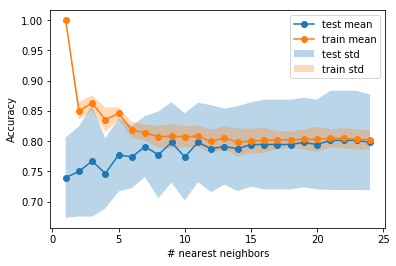

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

param_grid = {'n_neighbors': np.arange(1, 25)}
n_knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=6, scoring='accuracy', refit=True, verbose=0, 
                          return_train_score=True)
n_knn_gscv.fit(nX, ny)

test_means = n_knn_gscv.cv_results_['mean_test_score']
test_stds = n_knn_gscv.cv_results_['std_test_score']
train_means = n_knn_gscv.cv_results_['mean_train_score']
train_stds = n_knn_gscv.cv_results_['std_train_score']
x_axis = param_grid['n_neighbors']

print(n_knn_gscv.best_params_)
print(n_knn_gscv.best_score_)
print(f'Best mean train accuracy: {np.max(train_means)} +/- {train_stds[np.argmax(train_means)]}')
print(f'Best mean test accuracy: {np.max(test_means)} +/- {test_stds[np.argmax(test_means)]}')

plt.figure()
plt.plot(x_axis, test_means, 'o-', label='test mean')
plt.fill_between(x_axis, test_means - test_stds, test_means + test_stds, label='test std', alpha=0.3)
plt.plot(x_axis, train_means, 'o-', label='train mean')
plt.fill_between(x_axis, train_means - train_stds, train_means + train_stds, label='train std', alpha=0.3)
plt.ylabel('Accuracy')
plt.xlabel('# nearest neighbors')
plt.legend()
plt.show()

## 2.1.2 Cross-validation: shake classifier

/home/ICT2000/jondras/anaconda3/envs/ICMI_head/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 15}
0.8908045977011494
Best mean train accuracy: 1.0 +/- 0.0
Best mean test accuracy: 0.8908045977011494 +/- 0.038322546495471295


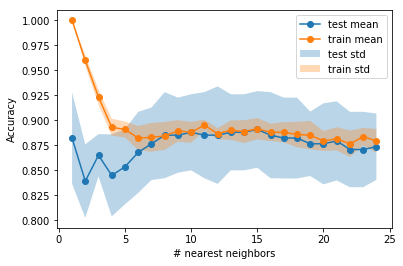

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

param_grid = {'n_neighbors': np.arange(1, 25)}
s_knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=6, scoring='accuracy', refit=True, verbose=0, 
                          return_train_score=True)
s_knn_gscv.fit(sX, sy)

test_means = s_knn_gscv.cv_results_['mean_test_score']
test_stds = s_knn_gscv.cv_results_['std_test_score']
train_means = s_knn_gscv.cv_results_['mean_train_score']
train_stds = s_knn_gscv.cv_results_['std_train_score']
x_axis = param_grid['n_neighbors']

print(s_knn_gscv.best_params_)
print(s_knn_gscv.best_score_)
print(f'Best mean train accuracy: {np.max(train_means)} +/- {train_stds[np.argmax(train_means)]}')
print(f'Best mean test accuracy: {np.max(test_means)} +/- {test_stds[np.argmax(test_means)]}')

plt.figure()
plt.plot(x_axis, test_means, 'o-', label='test mean')
plt.fill_between(x_axis, test_means - test_stds, test_means + test_stds, label='test std', alpha=0.3)
plt.plot(x_axis, train_means, 'o-', label='train mean')
plt.fill_between(x_axis, train_means - train_stds, train_means + train_stds, label='train std', alpha=0.3)
plt.ylabel('Accuracy')
plt.xlabel('# nearest neighbors')
plt.legend()
plt.show()

## 2.2.1 Final training using all the data: nod classifier

In [7]:
# Use the best estimator from above or choose custom settings
n_knn_final = n_knn_gscv.best_estimator_
# n_knn_final = KNeighborsClassifier(n_neighbors=1)
n_knn_final.fit(nX, ny)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=2,
           weights='uniform')

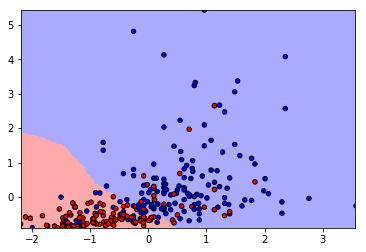

In [11]:
# Show the decision surface
from matplotlib.colors import ListedColormap

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = nX[:, 0].min(), nX[:, 0].max()
y_min, y_max = nX[:, 1].min(), nX[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = n_knn_final.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(nX[:, 0], nX[:, 1], c=ny, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## 2.2.2 Final training using all the data: shake classifier

In [8]:
# Use the best estimator from above or choose custom settings
s_knn_final = s_knn_gscv.best_estimator_
# s_knn_final = KNeighborsClassifier(n_neighbors=1)
s_knn_final.fit(sX, sy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

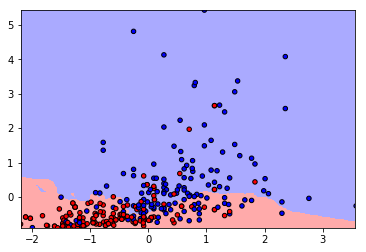

In [12]:
# Show the decision surface
from matplotlib.colors import ListedColormap

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = nX[:, 0].min(), nX[:, 0].max()
y_min, y_max = nX[:, 1].min(), nX[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = s_knn_final.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(nX[:, 0], nX[:, 1], c=ny, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## 2.3 Evaluate fused kNN

In [12]:
from sklearn.metrics import classification_report, accuracy_score

class FusedKNN():
    
    def __init__(self, nod_knn, shake_knn):
        self.nod_knn = nod_knn
        self.shake_knn = shake_knn
        self.class_names = ['other', 'nod', 'shake']
        
    def predict(self, X_znormed):
        
        assert X_znormed.shape[1] == 4
        
        nod_X   = self.nod_knn.predict_proba(X_znormed[:, [0,1]])[:, 1]
        shake_X = self.shake_knn.predict_proba(X_znormed[:, [2,3]])[:, 1]
        
        y_pred = []
        for p_n, p_s in zip(nod_X, shake_X):         
        
            # Assign other class
            if p_n <= 0.5 and p_s <= 0.5:
                ann = 0
            # Assign shake class
            elif p_n <= 0.5:
                ann = 2
            # Assign nod class
            elif p_s <= 0.5:
                ann = 1
            # Assign higher-probability nod/shake class
            else:
                ann = 1 if p_n >= p_s else 2

            y_pred.append(ann)
        
        return y_pred
    
    def evaluate(self, X_znormed, y_true):
        y_pred = self.predict(X)
        print(classification_report(y_true, y_pred, target_names=self.class_names))
        print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
        
        
head_classes = ['other', 'nod', 'shake']
angle_types = ['x', 'y']

# Construct feature matrix X and vector of labels y
X = []
y = []

for head_class_idx, head_class in enumerate(head_classes):
    
    input_dir = input_dir_prefix + head_class
    per_class_X = []
    
    for angle_type in angle_types:
        widths, heights = get_peaks_params(input_dir, angle_type=angle_type, include_nan=True)
        per_class_X.extend([widths, heights])
        print(len(widths), len(heights))
        
    print(np.array(per_class_X).T.shape)
    X.append(np.array(per_class_X).T)
    y.extend([head_class_idx] * len(X[-1]))
    print(len(X), len(y))
        
X = np.vstack((X))
y = np.array(y)
print(X.shape, y.shape)

# Remove nan rows
y = np.array([y[i] for i in range(len(X)) if not np.isnan(X[i]).any()])
X = np.array([X[i] for i in range(len(X)) if not np.isnan(X[i]).any()])
print(X.shape, y.shape)
print(np.unique(y, return_counts=True))
print(y)
    
# Z-normalize features
X[:, [0, 1]] = n_znorm_scaler.transform(X[:, [0, 1]])
X[:, [2, 3]] = s_znorm_scaler.transform(X[:, [2, 3]])

# Random oversampling of minority classes
random_state = 37
ros = RandomOverSampler(random_state=random_state)
X, y = ros.fit_resample(X, y)
print(X.shape, y.shape, 143*3)

fused_knn = FusedKNN(n_knn_final, s_knn_final)
fused_knn.evaluate(X, y)

25 25
25 25
(25, 4)
1 25


/home/ICT2000/jondras/anaconda3/envs/ICMI_head/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ICT2000/jondras/anaconda3/envs/ICMI_head/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


154 154
154 154
(154, 4)
2 179
104 104
104 104
(104, 4)
3 283
(283, 4) (283,)
(249, 4) (249,)
(array([0, 1, 2]), array([ 25, 143,  81]))
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

       other       0.79      1.00      0.88       143
         nod       0.94      0.79      0.86       143
       shake       0.95      0.85      0.90       143

   micro avg       0.88      0.88      0.88       429
   macro avg       0.89      0.88      0.88       429
weighted avg       0.89      0.

# 3. Predict

## 3.1 Peak counts

Using binary classifiers independently, count number of nods and number of shakes per recording.

In [10]:
from utils import annotate_dataframe, FRAME_RATE
import glob
import pandas as pd

# Uses dcaps and nvb folders
input_dir = '/home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/*/segment'
# output_filename_suffix = 'HEAD2'

output_filename = '/home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/head2_counts.csv'

output_file_header = ['filename', 'total_duration', 'nod_count', 'shake_count']
verbose = True
verbose = False

filenames = []
total_durations = []
nod_cnts = []
shake_cnts = []

dcaps_cnt = 0
nvb_cnt = 0
# For each file
for csv_file in glob.glob(os.path.join(input_dir, '*/*/*_FACE.csv')):
        
    if 'dcaps' in csv_file:
        dcaps_cnt += 1
    elif 'nvb' in csv_file:
        nvb_cnt += 1
        
    print(f'Processing {csv_file}')
    df = pd.read_csv(csv_file)
    nod_annotations, nod_angles, nod_peak_cnt = annotate_dataframe(df, angle_type='x', clf=n_knn_final, scaler=n_znorm_scaler, verbose=verbose)
    shake_annotations, shake_angles, shake_peak_cnt = annotate_dataframe(df, angle_type='y', clf=s_knn_final, scaler=s_znorm_scaler, verbose=verbose)
    filenames.append(csv_file.split('/')[-1])
    total_durations.append(len(nod_angles) / FRAME_RATE)
    nod_cnts.append(nod_peak_cnt)
    shake_cnts.append(shake_peak_cnt)
    
# Save all peak counts as a new csv file
out_df = pd.DataFrame(np.array([filenames, total_durations, nod_cnts, shake_cnts]).T, columns=output_file_header)
out_df.to_csv(output_filename)
        
print(f'\n\n\nProcessed {dcaps_cnt} dcaps files, {nvb_cnt} nvb files.')


Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_EventToErase/483_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_MostProudOf/483_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_LastTimeHappy/483_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_HardestDecision/483_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_SituationHandledDifferent/483_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/483/483_LastArgument/483_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/466/466_MostProudOf/466_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-h

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/427/427_HardestDecision/427_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/427/427_HowCloseToFamily/427_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/697/697_HardestDecision/697_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/697/697_EventToErase/697_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/697/697_Guilty/697_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/697/697_LastTimeHappy/697_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/697/697_LastArgument/697_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/364/364_HowCloseToFamily/364_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/364/364_LastArgument/364_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/454/454_EventToErase/454_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/454/454_HardestDecision/454_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/454/454_LastTimeHappy/454_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/454/454_HowCloseToFamily/454_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/454/454_LastArgument/454_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-mo

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_SituationHandledDifferent/440_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_LastTimeHappy/440_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_HardestDecision/440_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_LastArgument/440_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_MostProudOf/440_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/440/440_HowCloseToFamily/440_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/444/444_LastTimeHappy/444_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jo

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/707/707_SituationHandledDifferent/707_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/707/707_MostProudOf/707_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/707/707_Guilty/707_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/691/691_SituationHandledDifferent/691_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/691/691_LastArgument/691_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/691/691_LastTimeHappy/691_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/691/691_Guilty/691_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-hea

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_SituationHandledDifferent/716_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_LastTimeHappy/716_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_HardestDecision/716_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_LastArgument/716_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_EventToErase/716_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_HowCloseToFamily/716_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/716/716_Guilty/716_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-h

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/664/664_EventToErase/664_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/664/664_LastTimeHappy/664_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/664/664_HowCloseToFamily/664_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/664/664_LastArgument/664_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/664/664_SituationHandledDifferent/664_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/669/669_EventToErase/669_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/669/669_LastArgument/669_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/650/650_LastTimeHappy/650_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/650/650_MostProudOf/650_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/650/650_EventToErase/650_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/650/650_LastArgument/650_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/467/467_SituationHandledDifferent/467_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/467/467_HowCloseToFamily/467_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/467/467_LastArgument/467_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/IC

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/432/432_MostProudOf/432_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/432/432_HardestDecision/432_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/432/432_LastArgument/432_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/712/712_EventToErase/712_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/712/712_Guilty/712_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/712/712_HardestDecision/712_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/712/712_SituationHandledDifferent/712_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-mo

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_SituationHandledDifferent/660_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_HardestDecision/660_HardestDecision_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_LastTimeHappy/660_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_MostProudOf/660_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_HowCloseToFamily/660_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_Guilty/660_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/660/660_EventToErase/660_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-hea

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/484/484_LastArgument/484_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/484/484_EventToErase/484_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/484/484_SituationHandledDifferent/484_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/703/703_LastArgument/703_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/703/703_LastTimeHappy/703_LastTimeHappy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/703/703_SituationHandledDifferent/703_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/703/703_EventToErase/703_EventToErase_FACE.csv
Processing /hom

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/387/387_SituationHandledDifferent/387_SituationHandledDifferent_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/387/387_Guilty/387_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/387/387_LastArgument/387_LastArgument_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/387/387_EventToErase/387_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/492/492_MostProudOf/492_MostProudOf_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/492/492_EventToErase/492_EventToErase_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/dcaps/segment/492/492_HowCloseToFamily/492_HowCloseToFamily_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Fantasy/AGN51M0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Hometown/AGN51M0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Time/AGN51M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Hate/AGN51M0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Disappointment/AGN51M0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Guilty/AGN51M0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN51M0/AGN51M0_Proud/AGN51M0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG13M1/EDG13M1_Fantasy/EDG13M1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG13M1/EDG13M1_Dislike/EDG13M1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG13M1/EDG13M1_Old/EDG13M1_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG13M1/EDG13M1_Time/EDG13M1_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG30F0/EDG30F0_Hometown/EDG30F0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG30F0/EDG30F0_Hate/EDG30F0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG30F0/EDG30F0_Time/EDG30F0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG30F0/E

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN27F0/AGN27F0_Hurt/AGN27F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Proud/RAW28F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Hurt/RAW28F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Hate/RAW28F0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Time/RAW28F0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Hometown/RAW28F0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Old/RAW28F0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW28F0/RAW28F0_Dis

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Proud/EDG21M0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Guilty/EDG21M0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Time/EDG21M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Fantasy/EDG21M0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Disappointment/EDG21M0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG21M0/EDG21M0_Dislike/EDG21M0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW18M1/RAW18M1_Dislike/RAW18M1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW26F0/RAW26F0_Guilty/RAW26F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW26F0/RAW26F0_Proud/RAW26F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW26F0/RAW26F0_Hurt/RAW26F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN37F0/AGN37F0_Disappointment/AGN37F0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN37F0/AGN37F0_Guilty/AGN37F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN37F0/AGN37F0_Dislike/AGN37F0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN37F0/AGN37F0_Fantasy/AGN37F0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_da

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Fantasy/EDG36M1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Hate/EDG36M1_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Guilty/EDG36M1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Hometown/EDG36M1_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Time/EDG36M1_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Dislike/EDG36M1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36M1/EDG36M1_Old/EDG36M1_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG36

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Time/RAW40M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Dislike/RAW40M0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Disappointment/RAW40M0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Hurt/RAW40M0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Fantasy/RAW40M0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Hometown/RAW40M0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW40M0/RAW40M0_Old/RAW40M0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/n

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW31M0/RAW31M0_Time/RAW31M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW31M0/RAW31M0_Old/RAW31M0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW31M0/RAW31M0_Hate/RAW31M0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW35M0/RAW35M0_Guilty/RAW35M0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW35M0/RAW35M0_Dislike/RAW35M0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW35M0/RAW35M0_Hometown/RAW35M0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW35M0/RAW35M0_Disappointment/RAW35M0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Guilty/EDG24F1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Hurt/EDG24F1_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Dislike/EDG24F1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Disappointment/EDG24F1_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Proud/EDG24F1_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Fantasy/EDG24F1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG24F1/EDG24F1_Time/EDG24F1_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/n

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Hate/AGN47F0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Guilty/AGN47F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Fantasy/AGN47F0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Old/AGN47F0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Hometown/AGN47F0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Hurt/AGN47F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN47F0/AGN47F0_Proud/AGN47F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW20F0/R

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG18F0/EDG18F0_Proud/EDG18F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG18F0/EDG18F0_Old/EDG18F0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG18F0/EDG18F0_Guilty/EDG18F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG18F0/EDG18F0_Disappointment/EDG18F0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG03F1/EDG03F1_Dislike/EDG03F1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG03F1/EDG03F1_Old/EDG03F1_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG03F1/EDG03F1_Guilty/EDG03F1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/seg

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW05M0/RAW05M0_Hate/RAW05M0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Old/RAW10F0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Hurt/RAW10F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Hate/RAW10F0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Fantasy/RAW10F0_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Guilty/RAW10F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_Proud/RAW10F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW10F0/RAW10F0_D

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Proud/RAW32F0_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Hurt/RAW32F0_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Old/RAW32F0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Hometown/RAW32F0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Guilty/RAW32F0_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Dislike/RAW32F0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/RAW32F0_Hate/RAW32F0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW32F0/R

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG16M0/EDG16M0_Time/EDG16M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG16M0/EDG16M0_Hate/EDG16M0_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG16M0/EDG16M0_Hometown/EDG16M0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG16M0/EDG16M0_Dislike/EDG16M0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN46M0/AGN46M0_Old/AGN46M0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN46M0/AGN46M0_Hometown/AGN46M0_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN46M0/AGN46M0_Disappointment/AGN46M0_Disappointment_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN25M1/AGN25M1_Fantasy/AGN25M1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Guilty/RAW39F1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Dislike/RAW39F1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Old/RAW39F1_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Fantasy/RAW39F1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Hurt/RAW39F1_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW39F1/RAW39F1_Hometown/RAW39F1_Hometown_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Proud/AGN42F1_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Guilty/AGN42F1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Dislike/AGN42F1_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Fantasy/AGN42F1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Old/AGN42F1_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Hate/AGN42F1_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN42F1_Hurt/AGN42F1_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/AGN42F1/AGN

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW04M1/RAW04M1_Proud/RAW04M1_Proud_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW04M1/RAW04M1_Fantasy/RAW04M1_Fantasy_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW04M1/RAW04M1_Hate/RAW04M1_Hate_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW04M1/RAW04M1_Guilty/RAW04M1_Guilty_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/RAW04M1/RAW04M1_Hurt/RAW04M1_Hurt_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG35M0/EDG35M0_Time/EDG35M0_Time_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG35M0/EDG35M0_Dislike/EDG35M0_Dislike_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG35M0/E

Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG29M0/EDG29M0_Old/EDG29M0_Old_FACE.csv
Processing /home/ICT2000/jondras/ICMI-head-motion-detection/kalins_data/nvb/segment/EDG29M0/EDG29M0_Disappointment/EDG29M0_Disappointment_FACE.csv



Processed 727 dcaps files, 1080 nvb files.


## 3.2 Full per-frame annotations

Per-sample/per-frame predictions of other/nod/shake class - annotated by 0/1/2.

In [16]:
from utils import annotate_dataframe
import glob
import pandas as pd

# input_dir = './../test_data/'
input_dir = './../data/nod/'
output_dir = './../test_data/'
output_filename_prefix = 'anns2_'
output_file_header = ['nod probability', 'shake probability', 'annotation']
verbose = False
        
# For each file
for csv_file in glob.glob(os.path.join(input_dir, '*.csv')):
    print(f'Processing {csv_file}')
    df = pd.read_csv(csv_file)
    nod_annotations, nod_angles = annotate_dataframe(df, angle_type='x', clf=n_knn_final, scaler=n_znorm_scaler, 
                                                     verbose=verbose)
    shake_annotations, shake_angles = annotate_dataframe(df, angle_type='y', clf=s_knn_final, scaler=s_znorm_scaler, 
                                                         verbose=verbose)
    
    fused_annotations = []
    for n_ann, s_ann in zip(nod_annotations, shake_annotations):
        # Assign other class
        if n_ann <= 0.5 and s_ann <= 0.5:
            ann = 0
        # Assign shake class
        elif n_ann <= 0.5:
            ann = 2
        # Assign nod class
        elif s_ann <= 0.5:
            ann = 1
        # Assign higher-probability nod/shake class
        else:
            ann = 1 if n_ann >= s_ann else 2
            
        fused_annotations.append(ann)
    
    if verbose:
        print(f'\nFused annotations:\n{fused_annotations}')
        # Plot
        plt.figure(figsize=(12,12))
        plt.subplot(311)
        plt.imshow([fused_annotations], cmap='Blues')
        plt.axis('off')
        plt.subplot(312)
        plt.plot(nod_angles, '-o', label='nod raw angle')
        plt.legend()
        plt.subplot(313)
        plt.plot(shake_angles, '-o', label='shake raw angle')
        plt.legend()
        plt.tight_layout(h_pad=-1.5)
        plt.xlim(0, 50)
        plt.ylim(-0.4, 0.4)
        plt.show()
    
    # Save final_annotations as a new csv file
    ann_df = pd.DataFrame(np.array([nod_annotations, shake_annotations, fused_annotations]).T, columns=output_file_header)
    ann_df.to_csv(os.path.join(output_dir, output_filename_prefix + csv_file.split('/')[-1]))
    
#     break
    

csv frame rate: 50.0
L End reached - +
R End reached + -


AssertionError: 